# Installation
## Cytomine:
Using pip, you can do it with these two lines:
~~~
$ curl -s https://packagecloud.io/install/repositories/cytomine-uliege/Cytomine-python-client/script.python.sh | bash
$ pip install cytomine-python-client
~~~


# Import


In [ ]:
from cytomine import Cytomine
from cytomine.models import ProjectCollection, ImageInstanceCollection, AnnotationCollection
import getpass
import shapely
from shapely import wkt
from shapely.affinity import affine_transform
import cv2                             # OpenCV
from imgTools import display, multiDisplay
import os, sys
import logging
import segment_detector as sd
import numpy as np
from metrics_lines import metricNaive, metricFalseNeg, metricFalsePos, metricTot
from images_database.preprocess_eyes import img_eye_partial_preprocessing
from images_database.preprocess_soccer import preprocessSoccerImage
from images_database.augment_data_set_soccers import report_augmented_image_and_annotations

# Evaluation of line detection

TODO: for Jo : example of the metrics

In [ ]:
import evaluateSegDetec

resp = input("Do you want to evaluate the line detector of part1? This will takes 2-3 minutes. [y, n] : ")
if resp == 'y':
    evaluateSegDetec.evaluate()


# Conventional methods for ellipses detection

The goal here is to find ellipses in an image. The ellipses are then returned as a list of five parameters: the center position, the half lengths of the main axes and the orientation angle of the major axis. On the one hand, we can represent the ellipses and on the other hand count their number if we trust the algorithm enough. We can therefore compare this method to methods based on machine learning.

In order to solve this problem, four methods were explored but only two were selected.

## Ellipse Hough transform 

This method has been tried but not selected for further works due to slowness.

### Description
This method works like the usual hough transform. Depending on its implementation, it will take a certain number of points and accumulate the parameters of the ellipses that could pass through these points. Once all points have been tested, the accumulators are evaluated and all parameters exceeding a certain threshold are selected as good candidates to represent an ellipse. These parameters will then form the different ellipses detected by the algorithm.

### Pros
* Very robust against noise
* Very robust against partial occlusion
* Easy to implement / understand

### Cons
* Takes "age of the univers" to execute, not tractable for huge images
* Not suitable for embedded computing / live applications

## Hough transform with parameter separation

This method has been implemented up to center detection but not selected for further works due to high bias and low performance on images containing several ellipses.

### Description
This method is very similar to the previous one. Here what will be tried is to separate the imposing transform into several small transforms. The one we studied is the one presented by Le Troter et al. (Arc of ellipse detection for video image registration, 2005) . The idea is to first look for the center of the ellipses and then find the other parameters from the center. To do this, triplets of points are selected. For each of them, the most likely tangent is evaluated by filtering (a mask is created for each tangent and the one that most closely resembles the neighborhood of the point is chosen). 

Then, a property of the ellipses allows to find the center of the ellipse formed by these three points. In fact, we know that for two points, if we link the intersection of their tangent to their center, the line thus formed will pass through the center of the ellipse. The crossing of the two lines thus formed by the triplet is therefore the hypothetical centre of an ellipse. These centers are accumulated and the ones with the highest scores are chosen as actual ellipse centers.
Arc of ellipse detection for video image registration
From there, the three remaining parameters are accumulated.

### Pros
* Faster than Ellipse Hough transform
* Possibly suitable for embedded computing and live applications

### Cons
* Very sensitive to accuracy errors

## Ellipse detection by accumulation of the secondary axis

This method is fully implemented and used.

### Description

This technique follows what was proposed by Yonghong Xie and Qiang Ji (A New Efficient Ellipse Detection Method, 2002). The idea will be to consider all pairs of points as the main axis of an ellipse. Then, for all the other points, we'll pretend they're on the ellipse. From these three points (the new selected point and the ends of the major axis), the half length of the secondary axis is evaluated and accumulated. Major axes with a secondary axis whose score exceeds a certain threshold are retained as the parameters of an ellipse. As it is also possible to find the other parameters from what is known about the ellipse, the ellipse is totally known at this point. Indeed, the center of the ellipse corresponds to the center of the two points chosen as the ends of the major axis. The angle of the major axis can also be evaluated from these two points.

Two sub-implementations have been used here. The first is to remove the pixels from the image once an ellipse has been detected (this avoids duplicates). The other implementation keeps all ellipses but only returns the one that received the most votes. The second method has the advantage of being more accurate but it is also slower and does not detect more than one ellipse.

### Pros
* Way faster than Ellipse Hough transform
* Suitable for embedded computing and live applications

### Cons
* Sensitive to noise (as an example, this method doesn't work well on soccer images due to the lines. A solution would be to first remove the lines here).

### Demo

The demonstration uses our implementation of the Yonghong Xie and Qiang Ji algorithm with pixel removal. The algorithm has 6 parameters which are the minimum and maximum half lengths of the two main axes, the number of bags in the accumulator and the threshold. The images used are only from the eye dataset because it takes a long time to find the ellipses in soccer images as their 'white pixel / black pixel' ratio is higher. Also, the algorithm was implemented in python and not C++ or full numpy which tends to slow down the computation.


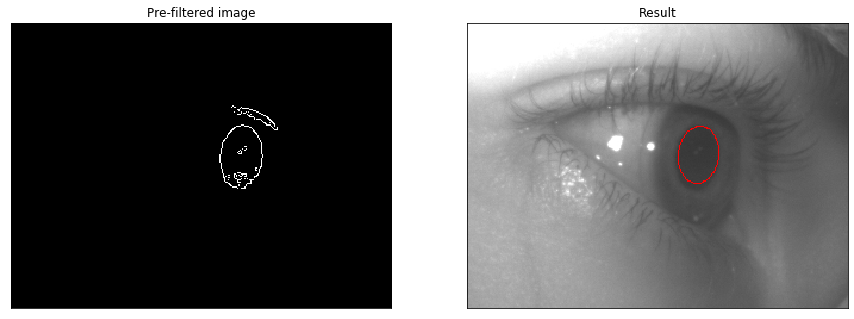

In [15]:
import classical as cl

original_eye = cv2.imread("./ReportImages/elps_eye01_2014-11-26_08-54-45-007.png", cv2.IMREAD_GRAYSCALE)
preprocess_eye = img_eye_partial_preprocessing(original_eye)

imageBinary = cv2.Canny(preprocess_eye, 20, 100)

ellipses = cl.youghongQiangEllipse(imageBinary, 15, 55, 5, 25, 40, 10, onlyBest=False, ratio=0.5)

imageBGR = cv2.cvtColor(original_eye, cv2.COLOR_GRAY2BGR)
for ell in ellipses:
    cv2.ellipse(imageBGR, ell[0], ell[1], ell[2], 0, 360, (0, 0, 255))
    
multiDisplay(["Pre-filtered image", "Result"], [imageBinary, imageBGR], 2)

Sometimes, the algorithm in this configuration detects 0 or more ellipses, not always a single one. This is why the "onlyBest" option is there to output only the best ellipse and not all those exceeding a certain threshold. However, the execution of this version of the algorithm is much slower. The reader can try it by modifying the "onlyBest" argument of the yongQiangEllipse function but the test is not performed by default in the notebook.  

# Preprocessing

The processing for the eyes and the soccer image dataset applied is different because of the different objective aims for each of them.

## Eyes

The aim for this dataset is to isolate the iris of the eye. This is done through multiple steps. The particularity of the iris is that it contains the darkest pixel of the images. So the main procedure will rely on increasing the contrast of the image. 

First, we proceed to a normalisation of the gray-scale image. Then we increase the contrast by multiplying all the grayscale values by a given factor. The factor has been chosen according to the value histogram of the whole dataset with some manual tuning. We had chosen to use a 15 factor because it was a good trade-off for isolating the iris and reduce the negative impact of some group of images with eye-liners which are of the same level of grey or darker than the iris.

Then, we apply a binary threshold by applying the Otsu algorithm to define the threshold. It succeeds globally in splitting the value histogram between the skin/rest of the eye and the iris (potentially eyelashes). These two successive operations are similar to an increase in contrast.  Finally, we finish the preprocessing with dilatation to close the shape of the iris. A close operation wasn't needed because they weren't any isolated small artifact after the increase in contrast.

In [ ]:
original_eye = cv2.imread("./ReportImages/elps_eye01_2014-11-26_08-54-45-007.png", cv2.IMREAD_GRAYSCALE)
preprocess_eye = img_eye_partial_preprocessing(original_eye)
multiDisplay(["Preprocess Eye", "Original Eye"], [original_eye, preprocess_eye], 2)

## Soccer

The aim for this dataset is to isolate the line of the soccer field the best as we can. This is rather more complex than the preceding context. The end of this process was inspired from a paper from the Sharif University of Technology in Iran. "Automatic Soccer Field Line Recognition by Minimum Information" : http://confnews.um.ac.ir/images/41/conferences/aisp2015/183_3.pdf. 

The following step where apply to the image after blurring to reduce the complexity of some information and uniform the images in its different colour space.

We first take back our HSV mask approch from the first part of this project. By applying an HSV mask, we are able to catch all the pixel corresponding to the green spectrum by determining the range of the Hue value. The range was defined by the histogram and manual adjustment. This first step isolates most of the soccer field.

Then, we keep only the biggest non black 4-way connected component of the images in order to remove all artefact outside the soccer field. Before doing this, we apply a dilatation operation with a horizontal rectangle kernel. Because, when processing a image from the side of the field, the central line of the field is composed of white value corresponding to the whole Hue range and some dirt (brown Hue range) could be observed on its border in a considerable number of pixels. This issue splits the soccer field into two 4-way connected components. But the horizontal rectangle dilatation succeeds in connected these two components without connecting them to outsider artefacts. 

When this is done, we add the remaining White value missing from the first mask by applying a range on the saturation and the value, low saturation range [0, 30] and high value [190, 255]. These values were defined by observation on some case because the histogram wasn't helping significantly to identify a pic. After applying the 2nd HSV mask, we proceed again in an isolation of the biggest 4-way connected component.  

The last part is focused on retrieving the lines. The quote paper explains the approach we apply in a small section. The main idea is to proceed to a median filtering in the LAB colour space on the L channel only. The L channel represents luminescence value and is not equivalent to the Grey Scale nor the Value channel of HSV because it applies a nonlinear transformation of the RGB space. This colour space is slightly better for filtering operation because it better dissociates brightness and chromatic data. The median filtering will help to uniform the luminescence over the soccer field and its dimension were chosen to be able to drop the luminescence data from the white line. Then we subtract the image before the operation and the filtered image. After applying a binary threshold (\[0, 10\]\[11, 255\]) and remove small connected component (closing operation could have wipe out thin white lines), we have our final prepossessing image which consists of all bright pixel on the soccer field.

In [ ]:
original_soccer = cv2.imread("./ReportImages/elps_soccer01_1024.png", cv2.IMREAD_COLOR)
preprocess_soccer = preprocessSoccerImage(original_soccer)
multiDisplay(["Preprocess Soccer", "Original Soccer"], [original_soccer, preprocess_soccer], 2)

## Data Augmentation

The objective was to extend the dataset of soccer images because it is by far the most complicated case for the deep learning model. In order to get synthetic images with synthetic annotations, we based our approach on the already preprocessed dataset from the original soccer images dataset. Because the preprocessing parameters are really sensible to a certain level of zoom and we aren't sure of how the preprocess of modified images will result. It is also a good way to save resources and to get as fast as possible new data. The lines are already extracted so we applied changes to these images to simulate plausible contexts. We are using the following affine transformations:

- Horizontal Flip
- Zoom [0.8, 0.95] (Zoom in) & [1.2, 2] (Zoom out)
- Shift according to y axis  +/- [0.05 * height, 0.2 * height]

The parameter used are chosen from the previous range according to a uniform law to not bias the simulation and to get something different from the original prepossessed image. Because shifting according to x and zoom in are excluding ellipses from the bounds, we didn't apply or restraint the factor. We use this new augmented dataset according to the variation in accuracy in the model.

In [ ]:
soccer_image = cv2.imread("./ReportImages/elps_soccer01_1056.png" , cv2.IMREAD_GRAYSCALE)
flip_image = report_augmented_image_and_annotations("FLIP", soccer_image, "elps_soccer01_1056.png", "ReportImages/CV2019_Annots_ElpsSoccer.csv")
zoom_image = report_augmented_image_and_annotations("ZOOM", soccer_image, "elps_soccer01_1056.png", "ReportImages/CV2019_Annots_ElpsSoccer.csv")
shift_image = report_augmented_image_and_annotations("SHIFT", soccer_image, "elps_soccer01_1056.png", "ReportImages/CV2019_Annots_ElpsSoccer.csv")

multiDisplay(["Original Image", "Horizontal Flipped Image", "Zoom In Image", "Shift Up Image"], [soccer_image, flip_image, zoom_image, shift_image], 2)
